In [206]:
from scipy.stats import distributions as iid
import scipy.stats
import numpy as np
from matplotlib import pyplot as plt


In [207]:
# create dgp 
def dgp(N, beta, pi):
    
    # get appropriate dimensions
    l = pi.shape[0]
    
    # generate disturbance terms and random Z
    u = iid.norm().rvs(size = (N,1))
    v = iid.norm().rvs(size = (N,1))
    Z = scipy.stats.multivariate_normal(np.zeros(l), np.eye(l)).rvs(size=N)
    if len(Z.shape) == 1:
        Z = Z.reshape(-1,1)
    
    X = Z@pi.reshape(-1,1) + v
    y = X*beta + u
    
    return y,X,Z

y,X,Z = dgp(10, 1, np.array([2]))

In [208]:
class tsls:
    def __init__(self, y,X,Z):
        self.y = y
        self.X = X
        self.Z = Z
    
    def beta_hat(self):
        xhat = self.Z@np.linalg.inv(self.Z.T@self.Z)@self.Z.T@self.X
        beta_tsls = np.linalg.solve(xhat.T@xhat, xhat.T@self.y)
        self.beta_tsls = beta_tsls
        
        return beta_tsls
    
    # get the standard errors and t stats 
    def se(self):
        e = self.y - self.beta_tsls*self.X
        vb = e.var()*np.linalg.inv(self.X.T@self.X) 
        se = np.sqrt(vb)
        self.se = se
        return se
    
    def tval(self):
        tstat = (self.beta_tsls)/self.se
        return tstat
        
    def ci(self, CI): # not quite working ... fml maybe should just use built in package I think you can.
        df = self.X.shape[0]-self.X.shape[1]
        ci = scipy.stats.t.interval(CI,df = df, loc=self.beta_hat, scale = self.se) 
        return ci


# test tsls
beta = 1
pi = np.array([1])

y,X,Z = dgp(100, beta, pi)
test = tsls(y,X,Z)
print(test.beta_hat())


[[1.01403559]]


In [209]:
def monteCarlo(N, beta, pi):
    y, X, Z = dgp(N, beta, pi)
    return tsls(y, X, Z).beta_hat()

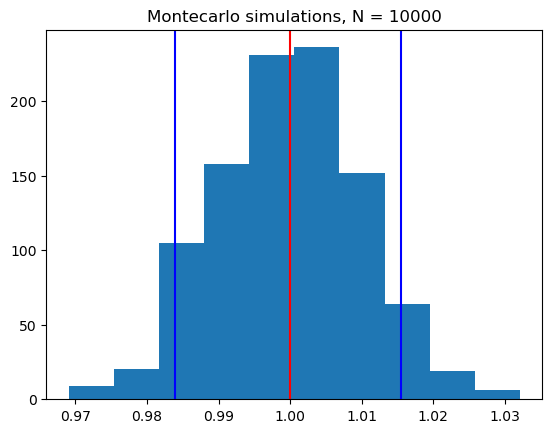

In [210]:
beta = 1
pi = np.array([1])
N = 10000

fig, ax = plt.subplots(1, 1) # initialize 3 subplots

# perform monte-carlo
beta_hats = [monteCarlo(N, beta, pi).item() for i in range(1000)]
    
# 95% of monte carlo
montecarlo_5th = np.percentile(beta_hats, 5)
montecarlo_95th = np.percentile(beta_hats, 95)

# plot
ax.hist(beta_hats)
ax.set_title(f"Montecarlo simulations, N = {N}")
ax.axvline(x=beta, color='r', label='True beta')
ax.axvline(x = montecarlo_5th, color = 'b')
ax.axvline(x = montecarlo_95th, color = 'b')


In [211]:
## compare the confidence intervals
print(montecarlo_5th)
print(montecarlo_95th)

y, X, Z = dgp(N, beta, pi)
tsls_reg = tsls(y,X,Z)
print(tsls_reg.ci(.95))

0.9839493585925985
1.0154569072378103


TypeError: '>' not supported between instances of 'method' and 'int'

In [ ]:
## now allowing pi to vary 
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 4, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 1000

# start empty list to save to
beta_hats = []

for p in [0.001, 0.01, 0.1, 1]:
    # calculate IV a bunch of times
    beta_hats = np.array([monteCarlo(N, beta, np.array([p])).item() for i in range(1000)])
    # some stats
    beta5 = np.percentile(beta_hats, 5)
    beta95 = np.percentile(beta_hats, 95)
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"pi = {p}; beta 95ci [{beta5:.1}, {beta95:.1}]")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1

error: (il>=1&&il<=n) failed for 6th keyword il: dsyevr:il=1

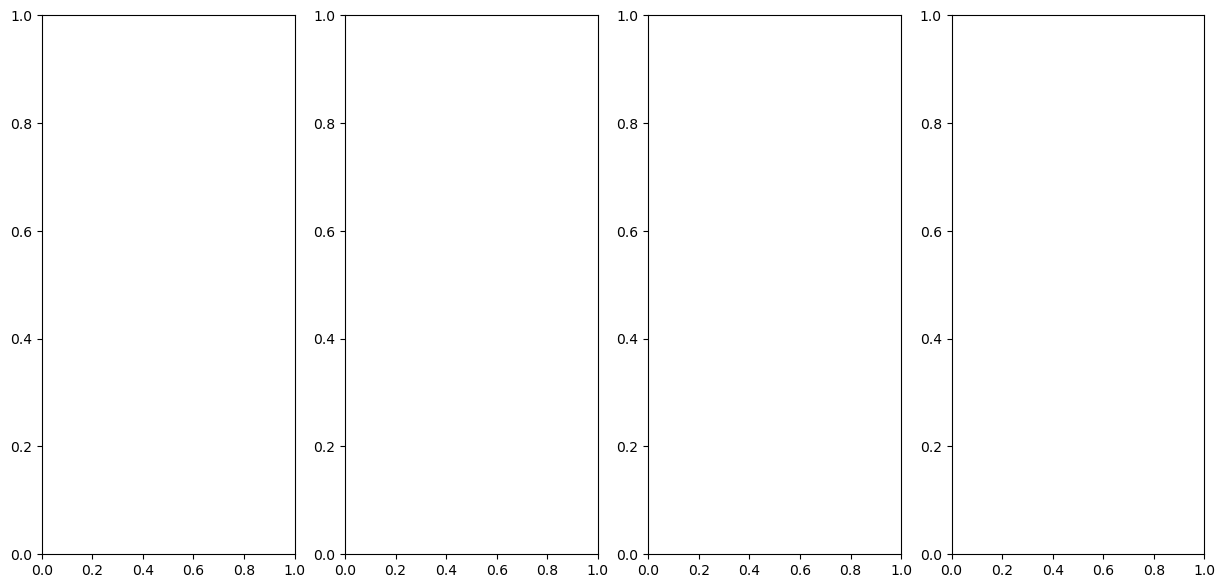

In [205]:
## increasing l
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 4, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 1000
pi = [1]
for i in range(10):
    pi.append(pi[i]*.5)

pi = np.array(pi)

# start empty list to save to
beta_hats = []

for i in range(1,5):
    # calculate IV a bunch of times
    beta_hats = np.array([monteCarlo(N, beta, pi[0:i]).item() for i in range(1000)])
    # some stats
    beta5 = np.percentile(beta_hats, 5)
    beta95 = np.percentile(beta_hats, 95)
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"l = {i}; beta 95ci [{beta5:.1}, {beta95:.1}]")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1

In [201]:
y,X,Z = dgp(N, beta, pi[0:4])
monteCarlo(y,X,Z) # it fucks up when generating u for some reason

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.